In [8]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
%pwd
%cd /Users/wenxindong/Desktop/Stanford/CS329P/project/riiid-test-answer-prediction
%ls
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

/Users/wenxindong/Desktop/Stanford/CS329P/project/riiid-test-answer-prediction
AutogluonModels/                       cv1_valid.pickle.zip
cv1_train.pickle                       cv1_valid_100k.pickle
cv1_train.pickle.zip                   example_sample_submission.csv
cv1_train_10000k.pickle                example_test.csv
cv1_train_10000k_preprocessed.pickle   lectures.csv
cv1_train_1000k.pickle                 questions.csv
cv1_train_1000k_preprocessed.pickle    riiid-test-answer-prediction.zip
cv1_train_100k.pickle                  riiideducation/
cv1_train_100k_preprocessed.pickle     test_4920_users.pickle
cv1_train_preprocessed.pickle          test_4920_users_preprocessed.pickle
cv1_val_100k_preprocessed.pickle       train.csv
cv1_val_10k.pickle                     train_39360_users.pickle
cv1_val_10k_preprocessed.pickle        train_39360_users_preprocessed.pickle
cv1_val_preprocessed.pickle            valid_4920_users.pickle
cv1_valid.pickle                       valid_4920_use

In [25]:
train_pickle = 'train_39360_users.pickle'  #about one tenth of the training dataset
valid_pickle = 'test_4920_users.pickle'   # too lazy to change name to test_pickle
question_file = 'questions.csv'
lecture_file = 'lectures.csv'

# Read data
train = pd.read_pickle(train_pickle)
valid = pd.read_pickle(valid_pickle)
lectures = pd.read_csv(lecture_file)
questions = pd.read_csv(question_file)
#subsample
train = train[:len(train)//10]
valid = valid[:len(valid)//10]


In [26]:
#Sort by time
train = train.sort_values(by=['timestamp'])
train = train.reset_index(drop=True)
valid = valid.sort_values(by=['timestamp'])
valid = valid.reset_index(drop=True)

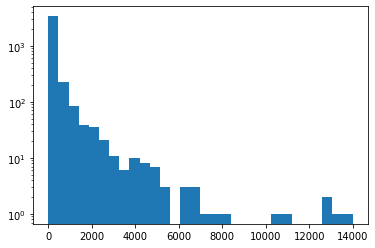

In [19]:
student_id, student_frequency = np.unique(train['user_id'], return_counts=True)

plt.hist(student_frequency, bins=30)
plt.yscale('log')
plt.show()

In [ ]:
threshold = 2000

print("# of Student ID having # of occurences higher than the threshold (" + str(threshold) + "): " + str(np.sum(student_frequency >= threshold)))

# of Student ID having # of occurences higher than the threshold (2000): 13


In [ ]:
#Drop other rows (We will not use the information of eachquestion that much)

#squarer = lambda t: t in keep_student_id
#vfunc = np.vectorize(squarer)
#drop_row = np.where(1-vfunc(np.array(train['user_id'])))[0]

keep_student_id = student_id[np.where(student_frequency >= threshold)[0]]
train = train.drop(np.where(1-train['user_id'].isin(keep_student_id))[0], axis=0)
train = train.reset_index(drop=True)
print("# of Training Entries: " + str(train.shape[0]))

# of Training Entries: 32932


In [27]:
train = train.drop(np.where(train['content_type_id'] == 1)[0], axis=0)
train = train.reset_index(drop=True)
print("# of Training Entries: " + str(train.shape[0]))

valid = valid.drop(np.where(valid['content_type_id'] == 1)[0], axis=0)
valid = valid.reset_index(drop=True)



# of Training Entries: 989400


In [28]:
#This is to map question_id into parts (Note that if we also want to include the lecture part, we can do so by concatenating questions.csv with lectures.csv)
train['part'] = np.array(questions['part'])[np.array(train['content_id'])]
valid['part'] = np.array(questions['part'])[np.array(valid['content_id'])]

In [29]:
#Should run only one time
train = train.drop(['row_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'prior_question_elapsed_time', 'prior_question_had_explanation'], axis=1)

#Sort lexiographically
train = train.sort_values(by=['user_id', 'timestamp'])
train = train.reset_index(drop=True)

train = train.drop(['timestamp'], axis=1)

In [30]:
#Should run only one time
valid = valid.drop(['row_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'prior_question_elapsed_time', 'prior_question_had_explanation'], axis=1)

#Sort lexiographically
valid = valid.sort_values(by=['user_id', 'timestamp'])
valid = valid.reset_index(drop=True)

valid = valid.drop(['timestamp'], axis=1)

In [ ]:
#Pruning so that each user has same length of history

#This can be run mulitple time

map = np.unique(train['user_id'])

mapmap = np.unique(train['user_id'], return_counts=True)[1]
minmin = np.min(mapmap)

lower = np.cumsum(mapmap)
upper = np.append(0, lower[:-1]) + minmin

drop_row = np.zeros(0)
for i in range(lower.size):
  drop_row = np.append(drop_row, np.arange(upper[i], lower[i]))

train = train.drop(drop_row, axis=0)

In [ ]:
#Run only once
train['part'] = train['part'] -1

In [ ]:
'''
#Run this only one time
t_train = torch.tensor(np.array(train))

#oNe hot enode + drop identity
t_train = torch.cat((t_train[:,1:-1], torch.nn.functional.one_hot(t_train[:,-1], num_classes=- 1)), dim=1)

number_user = np.size(mapmap)

t_train = t_train.view(number_user, int(t_train.shape[0] / number_user), -1)

t_train_y = t_train[:,:,0]
t_train_x = t_train[:,:,1:]
'''

'\n#Run this only one time\nt_train = torch.tensor(np.array(train))\n\n#oNe hot enode + drop identity\nt_train = torch.cat((t_train[:,1:-1], torch.nn.functional.one_hot(t_train[:,-1], num_classes=- 1)), dim=1)\n\nnumber_user = np.size(mapmap)\n\nt_train = t_train.view(number_user, int(t_train.shape[0] / number_user), -1)\n\nt_train_y = t_train[:,:,0]\nt_train_x = t_train[:,:,1:]\n'

In [ ]:
#Load into torch
t_train = torch.tensor(np.array(train))
#t_train = torch.cat((t_train[:,1:-1], torch.nn.functional.one_hot(t_train[:,-1], num_classes=- 1)), dim=1)
t_train = t_train[:,1:]
mapmap = np.unique(train['user_id'], return_counts=True)[1]
lower = np.cumsum(mapmap)
number_user = np.size(mapmap)

In [ ]:
#Nanobatch
nanobatch = np.random.randint(number_user)
nano_t_train = t_train[np.append(0, lower)[nanobatch] : lower[nanobatch]]
nano_t_train_x = nano_t_train[:,1:]
nano_t_train_y = nano_t_train[:,0]

In [ ]:
nano_t_train_x

tensor([[0],
        [0],
        [0],
        ...,
        [4],
        [4],
        [4]])

In [ ]:
nano_t_train[:,0]

tensor([0, 1, 1,  ..., 1, 0, 0])

In [ ]:
num_epoch = 200
num_step_per_epoch = 200
step_size = 1e-3

beta1=0.9
beta2=0.999
epsilon=1e-8


#Learnable parameters
Layers = dict()
Layers['L0_a'] = torch.randn(7, device=device, dtype=torch.float64, requires_grad=True)
Layers['T_a'] = torch.randn(7, device=device, dtype=torch.float64, requires_grad=True)
Layers['S_a'] = torch.randn(7, device=device, dtype=torch.float64, requires_grad=True)
Layers['G_a'] = torch.randn(7, device=device, dtype=torch.float64, requires_grad=True)

m = dict()
v = dict()
g = dict()
mh = dict()
vh = dict()
for namee in Layers.keys():
  m[namee] = torch.zeros_like(Layers[namee])
  v[namee] = torch.zeros_like(Layers[namee])
  g[namee] = torch.zeros_like(Layers[namee])
  mh[namee] = torch.zeros_like(Layers[namee])
  vh[namee] = torch.zeros_like(Layers[namee])


loss_array = np.zeros(0)
t = 0

for epoch in range(num_epoch):

  T = torch.sigmoid(Layers['T_a'])
  S = torch.sigmoid(Layers['S_a'])
  G = torch.sigmoid(Layers['G_a'])

  #Initilaize phase
  L = torch.sigmoid(Layers['L0_a'])
  loss = 0

  #Forward
  for i in range(nano_t_train.shape[0]):
    k = nano_t_train[i,1]
    obs = nano_t_train[i,0]
    C = L[k]*(1-S[k]) + (1-L[k])*(G[k])
    #Loss
    loss -= (torch.log(C)*obs + torch.log(1-C)*(1-obs))
    #Propagate
    Lobs = 1 / (1 + ((1-L[k]) * torch.abs(1-obs-G[k]) / L[k]/ torch.abs(obs-S[k])))
    mask = torch.zeros(7).to(device=device)
    mask[k] = 1
    L = L*(1-mask) + mask*(Lobs + (1-Lobs)*T[k])

  loss /= nano_t_train.shape[0]

  #print(loss)

  #Backward
  loss.backward()
  #print('Yay!')

  t += 1
  for namee in Layers.keys():
    g[namee] = Layers[namee].grad
    m[namee] = beta1 * m[namee] + (1 - beta1) * g[namee]
    v[namee] = beta2 * v[namee] + (1 - beta2) * torch.square(g[namee])
    mh[namee] = m[namee] / (1 - np.power(beta1, t)) + (1 - beta1) * g[namee] / (1 - np.power(beta1, t))
    vh[namee] = v[namee] / (1 - np.power(beta2, t))
    Layers[namee].data -= step_size * mh[namee] / (torch.sqrt(vh[namee]) + epsilon)
    Layers[namee].grad.data.zero_()
  
  loss_array = np.append(loss_array, float(loss))

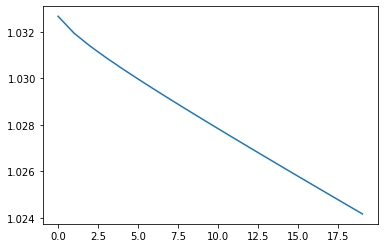

In [ ]:
plt.plot(loss_array)

In [ ]:
  for i in range(nano_t_train.shape[0]):
    k = nano_t_train[i,1]
    obs = nano_t_train[i,0]
    C = L[k]*(1-S[k]) + (1-L[k])*(G[k])

    loss -= (torch.log(C)*obs + torch.log(1-C)*(1-obs))

    Lobs = 1 / (1 + ((1-L[k]) * torch.abs(1-obs-G[k]) / L[k]/ torch.abs(obs-S[k])))
    L[k] = Lobs + (1-Lobs)*T[k]

  loss /= nano_t_train.shape[0]

In [ ]:
L = L0
loss = 0
for i in range(nano_t_train.shape[0]):
  k = nano_t_train[i,1]
  obs = nano_t_train[i,0]
  C = L[k]*(1-S[k]) + (1-L[k])*(G[k])

  loss -= (torch.log(C)*obs + torch.log(1-C)*(1-obs))

  Lobs = 1 / (1 + ((1-L[k]) * torch.abs(1-obs-G[k]) / L[k]/ torch.abs(obs-S[k])))
  L[k] = Lobs + (1-Lobs)*T[k]

In [ ]:
loss

tensor(1278.6415, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)

In [ ]:
L

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', dtype=torch.float64, grad_fn=<CopySlices>)

In [ ]:
#If use onehot encoding, L[k] = L @ e_k.
k = nano_t_train[i,1]
obs = nano_t_train[i,0]
C = L[k]*(1-S[k]) + (1-L[k])*(G[k])

loss = - (torch.log(C)*obs + torch.log(1-C)@(1-obs))

Lobs = 1 / (1 + ((1-L[k]) * torch.abs(1-obs-G[k]) / L[k]/ torch.abs(obs-S[k])))
L[k] = Lobs + (1-Lobs)*T[k]

In [ ]:
C

tensor(0.6992, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [ ]:
L

tensor([0.5369, 0.7646, 0.7528, 0.5567, 0.7886, 0.6209, 0.0747],
       device='cuda:0', dtype=torch.float64, grad_fn=<CopySlices>)

In [ ]:
1:  G
0: 1-G 

In [ ]:
obs

tensor(0)

In [ ]:
nano_t_train

tensor([[1, 0],
        [0, 0],
        [0, 0],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]])

In [ ]:
#initialize phase
L = L0

In [ ]:
t_train.view(number_user, int(t_train.shape[0] / number_user), -1)

RuntimeError: ignored

In [ ]:
L = torch.zeros_like(t_train_y)

In [ ]:
t_train.view(number_user, int(t_train.shape[0] / number_user), -1)

tensor([[[1, 0, 0,  ..., 1, 0, 0],
         [1, 0, 1,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 1, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 0, 0],
         [1, 0, 0,  ..., 1, 0, 0],
         [1, 0, 0,  ..., 1, 0, 0]],

        [[1, 0, 0,  ..., 1, 0, 0],
         [1, 0, 0,  ..., 1, 0, 0],
         [1, 0, 0,  ..., 1, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 1, 0],
         [1, 0, 0,  ..., 0, 1, 0],
         [1, 0, 0,  ..., 0, 1, 0]],

        [[0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         ...,
         [1, 0, 1,  ..., 0, 0, 0],
         [1, 0, 1,  ..., 0, 0, 0],
         [1, 0, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0,

In [ ]:
t_train.view(number_user, int(t_train.shape[0] / number_user), -1)

In [ ]:
torch.cat()

In [ ]:
torch.nn.functional.one_hot(t_train[:,-1], num_classes=- 1)

tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]])

In [ ]:
t_train.view(number_user, int(t_train.shape[0] / number_user), -1)

tensor([[[ 0,  1,  4],
         [ 0,  1,  1],
         [ 0,  1,  4],
         ...,
         [ 0,  0,  4],
         [ 0,  1,  4],
         [ 0,  1,  4]],

        [[ 1,  1,  4],
         [ 1,  1,  4],
         [ 1,  1,  4],
         ...,
         [ 1,  0,  5],
         [ 1,  1,  5],
         [ 1,  1,  5]],

        [[ 2,  0,  4],
         [ 2,  0,  4],
         [ 2,  0,  4],
         ...,
         [ 2,  1,  1],
         [ 2,  1,  1],
         [ 2,  1,  1]],

        ...,

        [[26,  1,  4],
         [26,  0,  4],
         [26,  1,  0],
         ...,
         [26,  1,  2],
         [26,  1,  2],
         [26,  1,  2]],

        [[27,  1,  4],
         [27,  0,  4],
         [27,  0,  4],
         ...,
         [27,  0,  1],
         [27,  0,  1],
         [27,  1,  1]],

        [[28,  0,  4],
         [28,  1,  4],
         [28,  0,  1],
         ...,
         [28,  1,  4],
         [28,  1,  4],
         [28,  1,  4]]])

# Empirical

In [31]:
def prep_data_BKT(data_df, part_id):
  train0 = data_df[data_df['part']==part_id]
  train0.reset_index(inplace=True)
  map, counts = np.unique(train0['user_id'], return_counts=True)
  cum_counts = np.cumsum(counts)
  start_idxs = np.append(0, cum_counts)
  return train0, start_idxs
def evaluate_BKT(train0, C, P_L0, P_T, P_G, P_S, start_idxs):
  #for every student
  predictions = []
  for i in range(len(start_idxs)-1):
    L = P_L0
    student_history = np.array(train0["answered_correctly"][start_idxs[i]: start_idxs[i+1]])
    for answer in student_history:
      prediction = L*(1-P_S) + (1-L)*P_G
      predictions.append(prediction)
      P_L_obs= 0
      if answer==1:
        P_L_obs = (L*(1-P_S)) / (L*(1-P_S)+ (1-L)*P_G)
      else:
        P_L_obs = (L*(P_S)) / (L*(P_S)+ (1-L)*(1-P_G))
      L = P_L_obs + (1-P_L_obs)*P_T
  predictions = np.array(predictions)
  # print(predictions)
  # plt.scatter(C[np.where(C==1)]+np.where(C==1), predictions[np.where(C==1)], c = "red", s = 0.1)
  # plt.scatter(C[np.where(C==0)]+np.where(C==0), predictions[np.where(C==0)], c = "green", s = 0.1)
  # plt.show()
  bce_loss = np.sum(- C*np.log(predictions) - (1-C)*np.log(1-predictions))/len(predictions)
  acc = np.sum(C*(predictions>0.5) + (1-C)*(predictions<0.5))/len(predictions)
  return bce_loss, acc, predictions

def get_best_ki(student_history):
    len_history = len(student_history)
    total_ones = np.sum(student_history)
    max_acc = 0
    best_i = 0
    num_mistakes_before = 0
    num_correct_before = 0
    for i in range(len_history+1):
      #i = position of first green check 
      acc =num_mistakes_before + (total_ones - num_correct_before)
      if acc>max_acc:
        best_i  = i
        max_acc = acc
      if i<len_history and student_history[i] == 0:
        num_mistakes_before+=1
      if i<len_history and student_history[i] == 1:
        num_correct_before+=1
    return best_i

def fit_BKT(train0, start_idxs):

  K = []
  for i in range(len(start_idxs)-1):
    student_history = np.array(train0["answered_correctly"][start_idxs[i]: start_idxs[i+1]])
    best_i = get_best_ki(student_history)
    student_ki = [0 for _ in range(best_i)] + [1 for _ in range(len(student_history) -  best_i)]
    K.extend(student_ki)
  
  K = np.array(K)
  C = np.array(train0["answered_correctly"])
  P_L0 = np.mean(K[start_idxs[:-1]])
  P_T = np.sum(K[1:]*(1-K[:-1])) / np.sum((1-K[:-1]))
  P_G = np.sum(C*(1-K)) / np.sum((1-K))
  P_S = np.sum((1-C)*(K)) / np.sum((K))
  return P_L0, P_T, P_G, P_S, C, K

all_predictions = []
all_targets = []
for part in range(1,8):
  print("training BKT model for part {}".format(part))
  #training
  train0, start_idxs = prep_data_BKT(train, part)
  print("there are {} rows, {} students".format(len(train0), len(start_idxs)))
  P_L0, P_T, P_G, P_S, C, K = fit_BKT(train0, start_idxs)
  bce_loss, acc, predictions = evaluate_BKT(train0, C,  P_L0, P_T, P_G, P_S, start_idxs)
  print("Training BCE losss: {:.3f}, acc: {:.3f}".format(bce_loss, acc))  

  #testing
  valid0, start_idxs_valid = prep_data_BKT(valid, part)
  _, _, _, _, C, _ = fit_BKT(valid0, start_idxs_valid)
  bce_loss, acc, predictions = evaluate_BKT(valid0, C, P_L0, P_T, P_G, P_S, start_idxs_valid)
  all_predictions.extend(predictions)
  all_targets.extend(C)
  print("BCE losss: {:.3f}, acc: {:.3f}".format(bce_loss, acc))

training BKT model for part 1
there are 76299 rows, 2806 students
Training BCE losss: 0.545, acc: 0.761
BCE losss: 0.582, acc: 0.732
training BKT model for part 2
there are 188335 rows, 3471 students
Training BCE losss: 0.583, acc: 0.725
BCE losss: 0.586, acc: 0.723
training BKT model for part 3
there are 87788 rows, 2009 students
Training BCE losss: 0.577, acc: 0.724
BCE losss: 0.566, acc: 0.734
training BKT model for part 4
there are 83160 rows, 1946 students
Training BCE losss: 0.609, acc: 0.693
BCE losss: 0.592, acc: 0.711
training BKT model for part 5
there are 396050 rows, 3750 students
Training BCE losss: 0.650, acc: 0.639
BCE losss: 0.656, acc: 0.630
training BKT model for part 6
there are 108879 rows, 1976 students
Training BCE losss: 0.614, acc: 0.683
BCE losss: 0.625, acc: 0.679
training BKT model for part 7
there are 48889 rows, 1815 students
Training BCE losss: 0.589, acc: 0.711
BCE losss: 0.578, acc: 0.727


In [40]:
#calculate overall accuracy and AUC
accuracy = np.sum((np.array(all_predictions) >0) +0 == np.array(all_targets)+0) / len(all_targets)
print(f"overall accuracy on the test set is {accuracy}")
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(all_targets, all_predictions)
print(f"overall auc score is {auc}")

overall accuracy on the test set is 0.6721045417469034
overall auc score is 0.6094982534491316


In [ ]:
C[start_idxs[1]:start_idxs[2]]

array([0, 0, 1, 1], dtype=int8)

In [ ]:
i = 0

In [ ]:
K[start_idxs[i]:start_idxs[i+1]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
C = C[start_idxs[i]:start_idxs[i+1]]

In [ ]:
def create_K(C):
  K = np.ones_like(C)
  cum_sum = np.cumsum(C*2-1)
  if np.min(cum_sum)  > 0:
    return K
  K[:np.argmin(cum_sum)+1] = 0
  return K

In [ ]:
create_K(C)

array([0, 0, 0, 0, 0, 0, 0, 1, 1])

In [ ]:
C = np.array([1,1,0,0,1,0,0,1,0])

In [ ]:
cum_sum = np.cumsum(C*2-1)

In [ ]:
np.argmin(cum_sum)

6

In [ ]:
cum_sum > 0

array([ True,  True,  True, False, False, False, False, False, False,
       False])

In [ ]:
map, counts = np.unique(train0['user_id'], return_counts=True)

In [ ]:
Lnot = np.mean((train0.iloc[np.append(0, np.cumsum(counts)[:-1])])['answered_correctly'])

In [ ]:
C = np.array(train0.iloc[0:110]['answered_correctly'])

In [ ]:
import cvxpy as cp

In [ ]:
K = cp.Variable(110)
constraints = [cp.hstack((0, K)) - cp.hstack((K, 1)) <= 0]
obj = cp.Minimize(-K@C/110 - (1-K)@(1-C)/110 + 0.1*cp.sum_squares(cp.hstack((0, K)) - cp.hstack((K, 1))))
problemn = cp.Problem(obj, constraints)
problemn.solve()

-0.7380540946656713

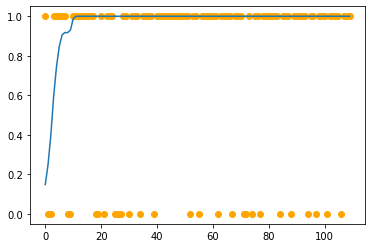

In [ ]:
plt.plot(K.value)
plt.scatter(np.arange(110),C, color='orange')

Expression(AFFINE, UNKNOWN, (110,))

# EM


In [ ]:
# E-step, fill in missing latent variables L
def E_step(train0, P_L0, P_T, P_G, P_S, start_idxs):
  Ls = []
  for i in range(len(start_idxs)-1):
    L = P_L0
    student_history = np.array(train0["answered_correctly"][start_idxs[i]: start_idxs[i+1]])
    for answer in student_history:
      P_L_obs= 0
      if answer==1:
        P_L_obs = (L*(1-P_S)) / (L*(1-P_S)+ (1-L)*P_G)
      else:
        P_L_obs = (L*(P_S)) / (L*(P_S)+ (1-L)*(1-P_G))
      
      newL = P_L_obs + (1-P_L_obs)*P_T
      Ls.append(newL)
      L = newL
  Ls = np.array(Ls)
  print("finished E step 0",P_L0)

  print("finished E step 1", np.unique(Ls[start_idxs[:-1]], return_counts=True))
  print("finished E step 2 ", np.array(train0["answered_correctly"]))
  return Ls

# def M_step(Cs, Ls, P_L0, P_T, P_G, P_S, start_idxs):
#   slip = np.sum((Ls>0.5)*(1-Cs)) / np.sum((Ls>0.5)) if np.sum(Ls>0.5)>0 else P_S
#   # slip = np.mean(1- (Cs - (1-Ls)*P_G) / Ls )
#   print("slip = ", slip)
#   guess = np.sum((Ls<0.5)*(Cs)) / np.sum((Ls<0.5)) if np.sum(Ls<0.5)>0 else P_G
#   # guess = np.mean( (Cs - Ls*(1-P_S))/(1-Ls+1e-8))
#   print("guess = ", guess)
#   L_0 = np.mean((Ls[start_idxs[:-1]] - P_T)/(1-P_T))
#   print("first states", Ls[start_idxs[:-1]])
#   print("L_0 = ", L_0)
#   transition = 0
#   count = 0

#   for i in range(len(start_idxs)-1):

#     student_L = Ls[start_idxs[i]: start_idxs[i+1]]
#   #   student_T = np.sum((student_L - np.append(P_L0, student_L[:-1] )) / (1-np.append(P_L0, student_L[:-1]) + 1e-8) )
#     count += np.sum((np.append(P_L0, student_L[:-1])<0.5))
#   #   transition+=student_T
#     transition += np.sum((np.append(P_L0, student_L[:-1])<0.5)*(student_L>0.5))
  
#   transition /=count
#   # transition = ((Ls<0.5))
#   print("transition = ", transition)
#   # print(transition)
#   return transition, guess, slip, L_0

def EM(part):
  print("training BKT using EM for part {}".format(part))
  train0, start_idxs_train = prep_data_BKT(train, part)
  Cs_train = np.array(train0["answered_correctly"])

  valid0, start_idxs_valid = prep_data_BKT(valid, part)
  Cs_valid = np.array(valid0["answered_correctly"])


  best_model = []
  best_bce_loss = float('inf')
  print("there are {} rows, {} students".format(len(train0), len(start_idxs_train)))
  for m in range(5):
    P_L0 = np.random.uniform(0.1, 0.3)
    P_T = np.random.uniform(0.1, 0.5)
    P_G = np.random.uniform(0.1, 0.5)
    P_S= np.random.uniform(0.1, 0.5)
    # print("starts with ", P_T, P_G, P_S, P_L0)
    bce_loss, acc = evaluate_BKT(train0, Cs_train, P_L0, P_T, P_G, P_S, start_idxs_train)
    print("random initialization - BCE losss: {:.3f}, acc: {:.3f}%".format(bce_loss, acc))
    prev_bce_loss = 0
    for i in range(100):
      Ls = E_step(train0, P_L0, P_T, P_G, P_S, start_idxs_train)
      P_T, P_G, P_S, P_L0 = M_step(Cs_train, Ls, P_L0, P_T, P_G, P_S, start_idxs_train)      
      bce_loss, acc = evaluate_BKT(train0, Cs_train, P_L0, P_T, P_G, P_S,start_idxs_train)
      print("BCE loss: {:.3f}, acc: {:.3f}%".format(bce_loss, acc))
      if abs(bce_loss - prev_bce_loss) < 1e-5:
        # print("ends with ", P_T, P_G, P_S, P_L0)
        # print("BCE losss: {:.3f}, acc: {:.3f}%".format(bce_loss, acc))
        break
      prev_bce_loss = bce_loss
    if prev_bce_loss < best_bce_loss:
      best_bce_loss = prev_bce_loss
      best_model = [P_L0, P_T, P_G, P_S]
      print("updated best model")
     
  bce_loss, acc = evaluate_BKT(valid0, Cs_valid, best_model[0], best_model[1], best_model[2], best_model[3], start_idxs_valid)
  print("final BCE loss: {:.3f}, acc: {:.3f}%".format(bce_loss, acc))
for part in range(1, 2):
  EM(part)

training BKT using EM for part 1
there are 95927 rows, 7955 students
random initialization - BCE losss: 0.625, acc: 0.661%
finished E step 0 0.15663961888701247
finished E step 1 (array([0.39363187, 0.53279221]), array([1894, 6060]))
finished E step 2  [0 0 0 ... 0 1 1]
slip =  0.27978233507892486
guess =  0.49018395419548294
first states [0.39363187 0.53279221 0.39363187 ... 0.53279221 0.53279221 0.53279221]
L_0 =  0.23986113971971182
transition =  1.7189456543925807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


BCE loss: nan, acc: 0.708%
finished E step 0 0.23986113971971182
finished E step 1 (array([1.4912072 , 1.61282285]), array([6060, 1894]))
finished E step 2  [0 0 0 ... 0 1 1]
slip =  -0.15534514622702056
guess =  0.990107061184552
first states [1.61282285 1.4912072  1.61282285 ... 1.4912072  1.4912072  1.4912072 ]
L_0 =  0.27648742326191633
transition =  0.2109725524541635


KeyboardInterrupt: ignored

In [ ]:
def evaluate_BKT(train0, P_L0, P_T, P_G, P_S):
  #for every student
  predictions = []
  for i in range(len(start_idxs)-1):
    L = P_L0
    student_history = np.array(train0["answered_correctly"][start_idxs[i]: start_idxs[i+1]])
    for answer in student_history:
      prediction = L*(1-P_S) + (1-L)*P_G
      predictions.append(prediction)
      P_L_obs= 0
      if answer==1:
        P_L_obs = (L*(1-P_S)) / (L*(1-P_S)+ (1-L)*P_G)
      else:
        P_L_obs = (L*(P_S)) / (L*(P_S)+ (1-L)*(1-P_G))
      L = P_L_obs + (1-P_L_obs)*P_T
  predictions = np.array(predictions)
  # print(predictions)
  # plt.scatter(C[np.where(C==1)]+np.where(C==1), predictions[np.where(C==1)], c = "red", s = 0.1)
  # plt.scatter(C[np.where(C==0)]+np.where(C==0), predictions[np.where(C==0)], c = "green", s = 0.1)
  # plt.show()
  bce_loss = np.sum(- C*np.log(predictions) - (1-C)*np.log(1-predictions))/len(predictions)
  acc = np.sum(C*(predictions>0.5) + (1-C)*(predictions<0.5))/len(predictions)
  return bce_loss, acc


In [ ]:
def M_step(Cs, Ls, P_L0, P_T, P_G, P_S, start_idxs):
  slip = np.sum((Ls)*(1-Cs)) / (np.sum(Ls) + 1e-8)
  # slip = np.mean(1- (Cs - (1-Ls)*P_G) / Ls )
  print("slip = ", slip)
  guess = np.sum((1-Ls)*(Cs)) / (np.sum((1-Ls)) + 1e-8)
  # guess = np.mean( (Cs - Ls*(1-P_S))/(1-Ls+1e-8))
  print("guess = ", guess)
  L_0 = np.mean((Ls[start_idxs[:-1]] - P_T)/(1-P_T))
  print("first states", Ls[start_idxs[:-1]])
  print("L_0 = ", L_0)
  transition = 0
  count = 0

  for i in range(len(start_idxs)-1):
    student_L = Ls[start_idxs[i]: start_idxs[i+1]]
    student_T = np.sum((student_L - np.append(P_L0, student_L[:-1] )) / (1-np.append(P_L0, student_L[:-1]) + 1e-8))
    count += np.sum(1-(np.append(P_L0, student_L[:-1])))
    transition+=student_T
    # transition += np.sum((1-np.append(P_L0, student_L[:-1]))*(student_L))
  
  transition /=count
  # transition = ((Ls<0.5))
  print("transition = ", transition)
  # print(transition)
  return transition, guess, slip, L_0


#Experiment